<h1>facc, or fish and chips classifier</h1>

We will use ~ 160 images to build an image classifier that produces 82-86% accuracy

Skip to sections:

- [Load data](#scrollTo=Ywv4rezV0pnO)
- [Data augmentation](#scrollTo=I3MpygsQ1Dee)
- [Training our model](#scrollTo=y09WlJ--5dC4)
- [Fine-tuning](#scrollTo=Ocp3eGag3Mj6)
- [Table of results](#scrollTo=MXdXRtcE3QSW)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/facc')

In [28]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

All images will have to be the same size, here we define **how many** images are in a **batch of data**, and the **image dimensions**

In [29]:
batch_size = 32
img_height = 256
img_width = 256

In [30]:
data_dir = 'facc_data'

## Load data

Load training and validation set from 2 files, 'fishandchipsimgs' and 'notfishandchipsimgs'


In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  )

Found 148 files belonging to 2 classes.
Using 119 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  )

Found 148 files belonging to 2 classes.
Using 29 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['fishandchipimgs', 'notfishandchipimgs']


See what our data looks like

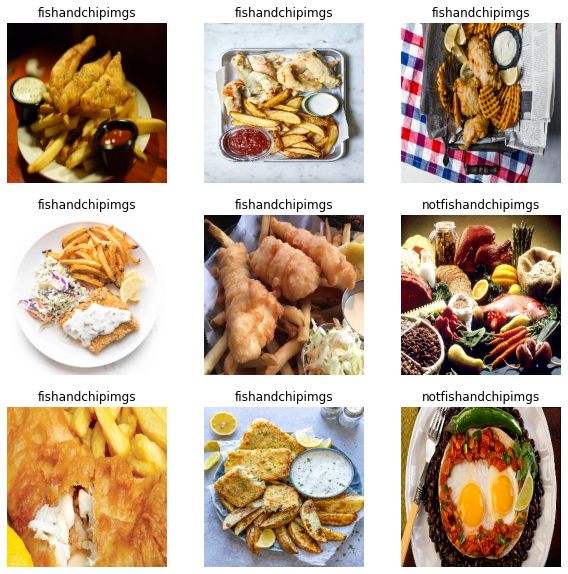

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


AUTOTUNE decides the number of images to **prefetch**, which makes loading our data during training faster.

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

## Data Augmentation

Define pipelines for preprocessing. Data augmentation produces **more training data** by **adding transformations** to them.

In [37]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [40]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In order to **prevent overfitting** (validation loss becomes worse than loss while training), we implement the** EarlyStopping** callback, so that the training loop will stop if our **validation loss** does not improve after **n** epochs. The hyperparameter **patience** specifies the **n**.

In [41]:
from keras.callbacks import EarlyStopping
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=5)

In [42]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [43]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Training our model

In [44]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[early_stopping_cb]
)

Epoch 1/20
4/4 [==============================] - 13s 2s/step - loss: 1.6583 - accuracy: 0.4202 - val_loss: 0.5743 - val_accuracy: 0.6897
Epoch 2/20
4/4 [==============================] - 13s 2s/step - loss: 0.7179 - accuracy: 0.3697 - val_loss: 0.5510 - val_accuracy: 0.8276
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 0.7314 - accuracy: 0.5126 - val_loss: 0.6310 - val_accuracy: 0.5172
Epoch 4/20
4/4 [==============================] - 12s 2s/step - loss: 0.6739 - accuracy: 0.5210 - val_loss: 0.5460 - val_accuracy: 0.7931
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 0.6287 - accuracy: 0.7479 - val_loss: 0.5197 - val_accuracy: 0.9310
Epoch 6/20
4/4 [==============================] - 12s 2s/step - loss: 0.5583 - accuracy: 0.7479 - val_loss: 0.3879 - val_accuracy: 0.8276
Epoch 7/20
4/4 [==============================] - 12s 2s/step - loss: 0.4829 - accuracy: 0.8151 - val_loss: 0.2013 - val_accuracy: 0.9310
Epoch 8/20
4/4 [==================

We got ~ 82 validation accuracy without too much overfitting! Let's see if we can use a base model and fine-tune it using our data.

## Fine-tuning

In [47]:
base_model = keras.applications.ResNet50(weights="imagenet",
                                         include_top=False,
                                         input_shape=(img_height, img_width, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [52]:
for layer in base_model.layers:
  layer.trainable = False

global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes)(global_avg_pooling)

fine_tuned_model = keras.models.Model(inputs=base_model.input,
                                      outputs=output)

In [53]:
fine_tuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

In [54]:
history = fine_tuned_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping_cb]
)

Epoch 1/20
4/4 [==============================] - 34s 7s/step - loss: 1.3040 - accuracy: 0.5210 - val_loss: 1.1039 - val_accuracy: 0.5862
Epoch 2/20
4/4 [==============================] - 30s 7s/step - loss: 0.9994 - accuracy: 0.5378 - val_loss: 1.1647 - val_accuracy: 0.4138
Epoch 3/20
4/4 [==============================] - 30s 7s/step - loss: 0.7264 - accuracy: 0.6723 - val_loss: 0.6967 - val_accuracy: 0.5862
Epoch 4/20
4/4 [==============================] - 30s 7s/step - loss: 0.7071 - accuracy: 0.5798 - val_loss: 0.4545 - val_accuracy: 0.6897
Epoch 5/20
4/4 [==============================] - 30s 7s/step - loss: 0.6992 - accuracy: 0.6975 - val_loss: 0.3347 - val_accuracy: 0.8966
Epoch 6/20
4/4 [==============================] - 30s 8s/step - loss: 0.6323 - accuracy: 0.6723 - val_loss: 0.3270 - val_accuracy: 0.8966
Epoch 7/20
4/4 [==============================] - 30s 8s/step - loss: 0.5567 - accuracy: 0.7731 - val_loss: 0.3420 - val_accuracy: 0.8966
Epoch 8/20
4/4 [==================

Got a 4% accuracy boost, that's pretty sweet!

## Table of results

|Model|Train accuracy|Validation accuracy|Epochs|
|-----|--------------|-------------------|------|
|Base model|0.61|0.5172|3|
|Data aug (flip, rotate)|0.5882|0.5862|3|
|Data aug (flip, rotate), early stop|0.8487|0.8276|17|
|pretrained ResNet50 w/ data aug, early stop|0.7731|0.8621|17|